## Load data

In [5]:
import os
os.chdir('..')

In [6]:
from src.dataset import *
from src.model import *
from src.train_test import *
import matplotlib.pyplot as plt
import pandas as pd
from torch import optim
from src.vis import *
from src.gradient import *

In [7]:
batch_size = 32
model_name = 'CIFAR17_add000'
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [8]:
# load data
train_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=True)
test_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=False)    


Files already downloaded and verified
Files already downloaded and verified


## Original model

In [6]:
model_name = 'CIFAR17_add000'

# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', total_trails=30)

### Get pos_grad_dict and neg_grad_dict

  1%|          | 11/1563 [00:00<00:14, 109.07it/s]

Compute correctly predicted data indices...
Trail 1


  1%|          | 12/1563 [00:00<00:13, 116.19it/s]

Trail 2


  1%|          | 13/1563 [00:00<00:12, 120.20it/s]

Trail 3


  1%|          | 14/1563 [00:00<00:11, 132.31it/s]

Trail 4


  1%|          | 13/1563 [00:00<00:12, 122.85it/s]

Trail 5


100%|██████████| 1563/1563 [00:13<00:00, 118.40it/s]


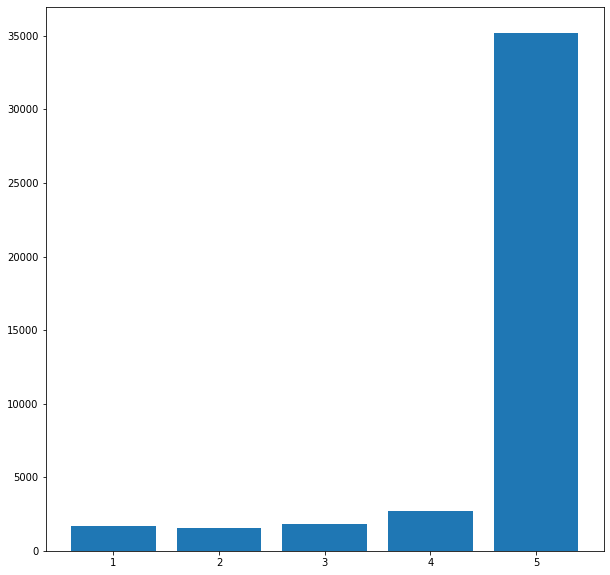

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 20/35194 [00:00<03:08, 186.51it/s]

Number of postive samples:  35194
Number of negative samples:  6928
Use trail 1 to compute conflicting gradients


  0%|          | 13/6928 [00:00<00:53, 128.67it/s]

Length of data 35194


100%|██████████| 6928/6928 [00:39<00:00, 175.51it/s]

Length of data 6928


In [45]:
model_name = 'CIFAR17_add434'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

pos_grad_dict, neg_grad_dict = get_graddict(model=model, 
                                            model_name=model_name, data_name='CIFAR10',
                                            train_data_loader=train_data_loader, num_trail=5, 
                                            pos_thre=5, neg_thre=0,
                                            compute_index=True, 
                                            vis=True, save=True)

### Weights contradiction visualization

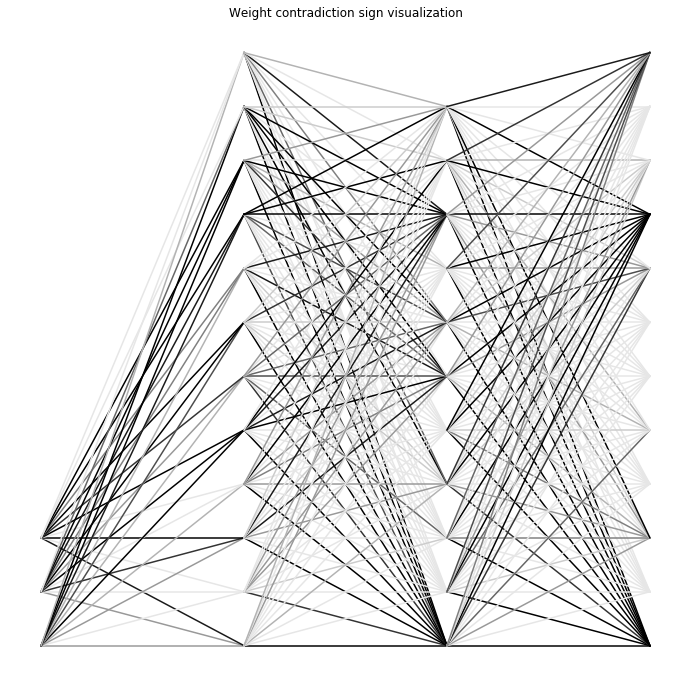

tensor([[0.1309, 0.0894, 0.7133],
        [0.0000, 0.0000, 0.0000],
        [0.3671, 0.8291, 1.0770],
        [0.3377, 0.0000, 0.0000],
        [1.8085, 1.9262, 2.1972],
        [0.0324, 0.1431, 0.6550],
        [0.3380, 0.7659, 1.0832],
        [0.1551, 0.2837, 0.3882],
        [0.7049, 0.9304, 1.3821],
        [0.5705, 0.6018, 0.4756],
        [0.7748, 0.3920, 0.0000],
        [0.4430, 0.0000, 0.0000]])
tensor([[0.3276, 0.1793, 0.4315, 0.3138, 0.2873, 0.1310, 0.3014, 0.3184, 0.2219,
         0.1685, 0.1524, 0.3323],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000, 0.0507, 0.0000, 0.0000, 0.0000, 0.1607, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0632, 0.0000, 0.1150, 0.0962, 0.0000, 0.0000, 0.0301, 0.0161, 0.0000,
         0.0000, 0.4885, 0.1987],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.0000,

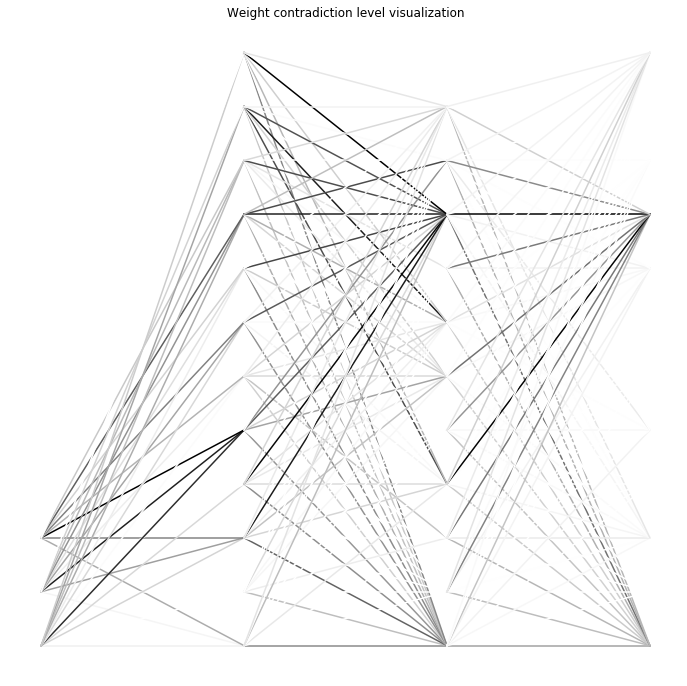

In [46]:
weight_contradict(pos_grad_dict, neg_grad_dict, method='sign')
weight_contradict(pos_grad_dict, neg_grad_dict, method='level')

### Get layer contradiction level

In [47]:
# avg/max of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.mean(dim=tuple(range(1, len(conflict_level.shape)))) # sum over kernel size
        
        layer_conflict_level = conflict_level.mean().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 0.060481395572423935
body.cnn2.conv.weight 0.01160789467394352
body.cnn3.conv.weight 0.013712252490222454
head.dense.fc1.weight 0.0055138543248176575
head.dense.fc2.weight 0.06631913036108017


In [48]:
# avg/max of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.mean(dim=tuple(range(1, len(conflict_level.shape)))) # sum over kernel size
        
        layer_conflict_level = conflict_level.max().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 0.21970020234584808
body.cnn2.conv.weight 0.05021229758858681
body.cnn3.conv.weight 0.08844343572854996
head.dense.fc1.weight 0.034143514931201935
head.dense.fc2.weight 0.17433355748653412


In [49]:
# variance of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.mean(dim=tuple(range(1, len(conflict_level.shape)))) # sum over kernel size
        
        layer_conflict_level = conflict_level.var().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 0.003600821830332279
body.cnn2.conv.weight 0.00023364000662695616
body.cnn3.conv.weight 0.0007587447762489319
head.dense.fc1.weight 7.445897063007578e-05
head.dense.fc2.weight 0.0022668028250336647


## Evolution Trace

In [22]:
for folder in os.listdir('checkpoints/'):
    if folder.startswith('CIFAR17-CIFAR10-model'):
        os.rename(os.path.join('checkpoints/', folder),
                 os.path.join('checkpoints/', 
                              'CIFAR17_add000-CIFAR10-model'+folder.split('CIFAR17-CIFAR10-model')[1]))

In [23]:
initial_trace = ['CIFAR17_add000', 'CIFAR17_add010', 'CIFAR17_add110', 'CIFAR17_add210']

logfile = open('log/train_trace.log').readlines()
for j in logfile:
    if 'INFO:trace:Update model name' in j:
        initial_trace.append(j.strip().split(' ')[-1])

In [24]:
initial_trace

['CIFAR17_add000',
 'CIFAR17_add010',
 'CIFAR17_add110',
 'CIFAR17_add210',
 'CIFAR17_add211',
 'CIFAR17_add212',
 'CIFAR17_add222',
 'CIFAR17_add232',
 'CIFAR17_add332',
 'CIFAR17_add333',
 'CIFAR17_add334',
 'CIFAR17_add434']

In [15]:
for trace in initial_trace:
    i,j,k = int(trace.split('add')[1][0]), \
            int(trace.split('add')[1][1]), \
            int(trace.split('add')[1][2]) # current index of model
    
    if 'lasti' in locals():
        incre_i, incre_j, incre_k = i-lasti, j-lastj, k-lastk
        ct = 1
        for layer in [incre_i, incre_j, incre_k]:
            if layer == 1:
                print('Increase {}th layer'.format(ct))
                break
            ct += 1
    
    lasti, lastj, lastk = i,j,k

Increase 2th layer
Increase 1th layer
Increase 1th layer
Increase 3th layer
Increase 3th layer
Increase 2th layer
Increase 2th layer
Increase 1th layer
Increase 3th layer
Increase 3th layer
Increase 1th layer


## Add one Conv filter

### Add to CNN1

  1%|          | 16/1563 [00:00<00:09, 155.06it/s]

Trail 1


  1%|          | 17/1563 [00:00<00:09, 165.75it/s]

Test set: Average loss: 0.7427, Accuracy: 37110/50000 (74%)

Trail 2


100%|██████████| 1563/1563 [00:09<00:00, 169.57it/s]


Test set: Average loss: 0.7480, Accuracy: 36958/50000 (74%)



  1%|          | 11/1563 [00:00<00:14, 109.27it/s]

Trail 3


  1%|          | 17/1563 [00:00<00:09, 164.06it/s]

Test set: Average loss: 0.7427, Accuracy: 36871/50000 (74%)

Trail 4


  1%|          | 17/1563 [00:00<00:09, 169.06it/s]

Test set: Average loss: 0.7445, Accuracy: 37000/50000 (74%)

Trail 5


100%|██████████| 1563/1563 [00:09<00:00, 168.33it/s]


Test set: Average loss: 0.7384, Accuracy: 36957/50000 (74%)



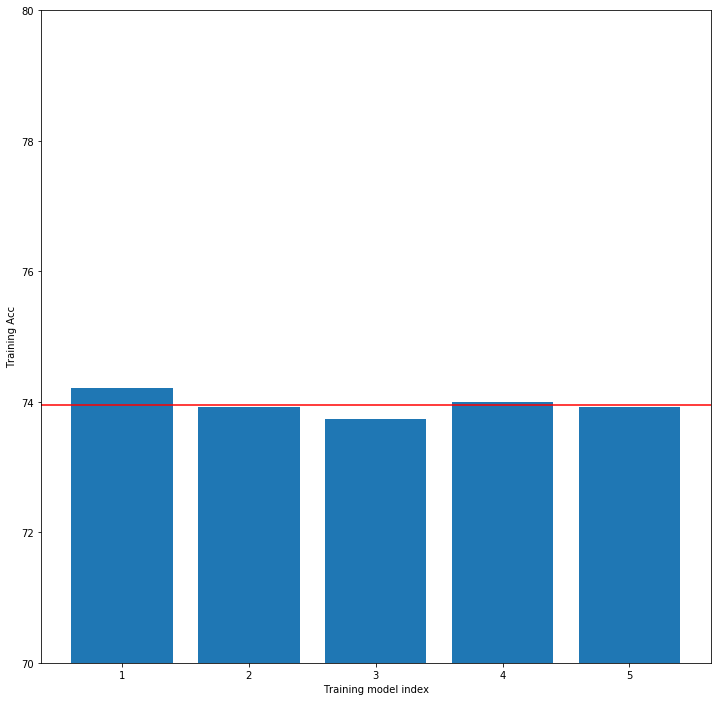

Average training acc: 73.9584


[74.22, 73.916, 73.742, 74.0, 73.914]

In [36]:
model_name = 'CIFAR17_add210'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc( model, train_data_loader,
                   model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN2

  1%|          | 15/1563 [00:00<00:10, 148.91it/s]

Trail 1


  1%|          | 18/1563 [00:00<00:08, 172.36it/s]

Test set: Average loss: 0.7492, Accuracy: 36846/50000 (74%)

Trail 2


  1%|          | 18/1563 [00:00<00:08, 172.79it/s]

Test set: Average loss: 0.7372, Accuracy: 37086/50000 (74%)

Trail 3


  1%|          | 18/1563 [00:00<00:08, 172.27it/s]

Test set: Average loss: 0.7431, Accuracy: 36895/50000 (74%)

Trail 4


  1%|          | 18/1563 [00:00<00:08, 171.93it/s]

Test set: Average loss: 0.7797, Accuracy: 36445/50000 (73%)

Trail 5


100%|██████████| 1563/1563 [00:09<00:00, 171.22it/s]


Test set: Average loss: 0.7310, Accuracy: 37277/50000 (75%)



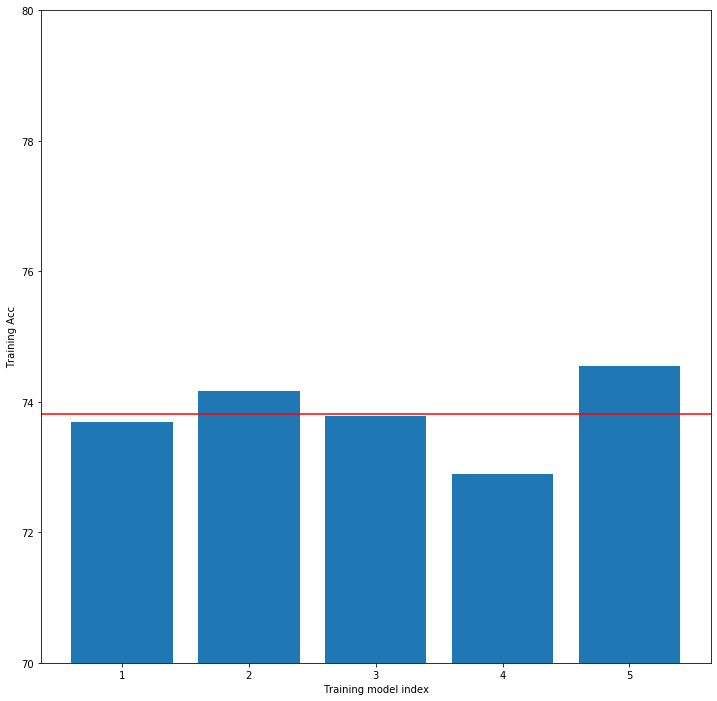

Average training acc: 73.8196


[73.692, 74.172, 73.79, 72.89, 74.554]

In [37]:
model_name = 'CIFAR17_add120'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  1%|          | 18/1563 [00:00<00:09, 170.66it/s]

Trail 1


  1%|          | 18/1563 [00:00<00:08, 174.67it/s]

Test set: Average loss: 0.8213, Accuracy: 35635/50000 (71%)

Trail 2


  1%|          | 18/1563 [00:00<00:08, 173.20it/s]

Test set: Average loss: 0.8037, Accuracy: 35811/50000 (72%)

Trail 3


  1%|          | 18/1563 [00:00<00:08, 176.00it/s]

Test set: Average loss: 0.8163, Accuracy: 35755/50000 (72%)

Trail 4


  1%|          | 18/1563 [00:00<00:08, 176.89it/s]

Test set: Average loss: 0.8108, Accuracy: 35733/50000 (71%)

Trail 5


100%|██████████| 1563/1563 [00:09<00:00, 173.54it/s]


Test set: Average loss: 0.8162, Accuracy: 35785/50000 (72%)



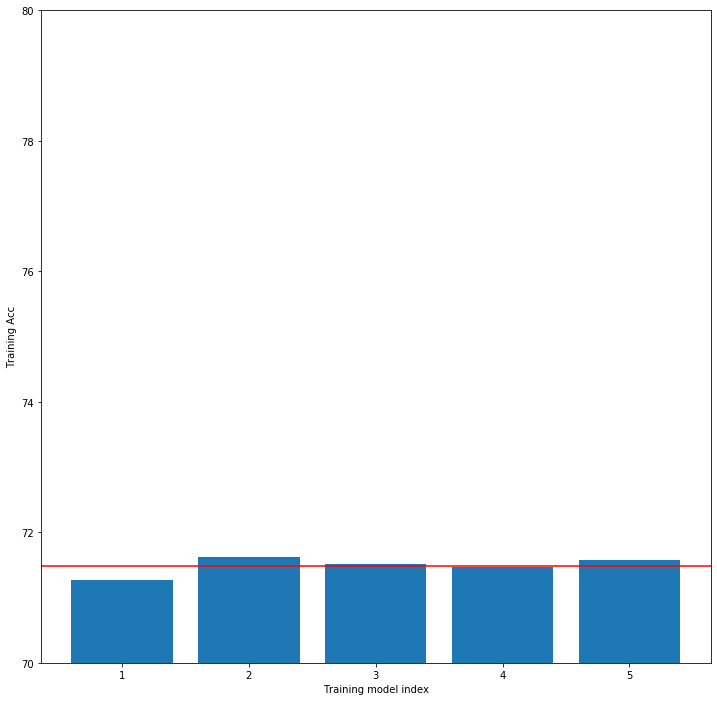

Average training acc: 71.4876


[71.27, 71.622, 71.51, 71.466, 71.57]

In [38]:
model_name = 'CIFAR17_add111'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', total_trails=5)

## Double the number of Conv filters

### Add to CNN1

In [35]:
model_name = 'CIFAR17_double1'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

TypeError: forward() missing 1 required positional argument: 'x'

### Add to CNN2

  1%|          | 11/1563 [00:00<00:15, 101.81it/s]

Trail 1


100%|██████████| 1563/1563 [00:12<00:00, 127.95it/s]


Test set: Average loss: 0.6700, Accuracy: 38133/50000 (76%)



  1%|          | 11/1563 [00:00<00:14, 109.59it/s]

Trail 2


  1%|          | 12/1563 [00:00<00:13, 115.55it/s]

Test set: Average loss: 0.6744, Accuracy: 38116/50000 (76%)

Trail 3


100%|██████████| 1563/1563 [00:12<00:00, 124.23it/s]


Test set: Average loss: 0.6689, Accuracy: 38182/50000 (76%)



  1%|          | 11/1563 [00:00<00:14, 106.75it/s]

Trail 4


100%|██████████| 1563/1563 [00:12<00:00, 128.54it/s]


Test set: Average loss: 0.6599, Accuracy: 38393/50000 (77%)



  1%|          | 11/1563 [00:00<00:14, 105.19it/s]

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 140.81it/s]


Test set: Average loss: 0.6662, Accuracy: 38159/50000 (76%)



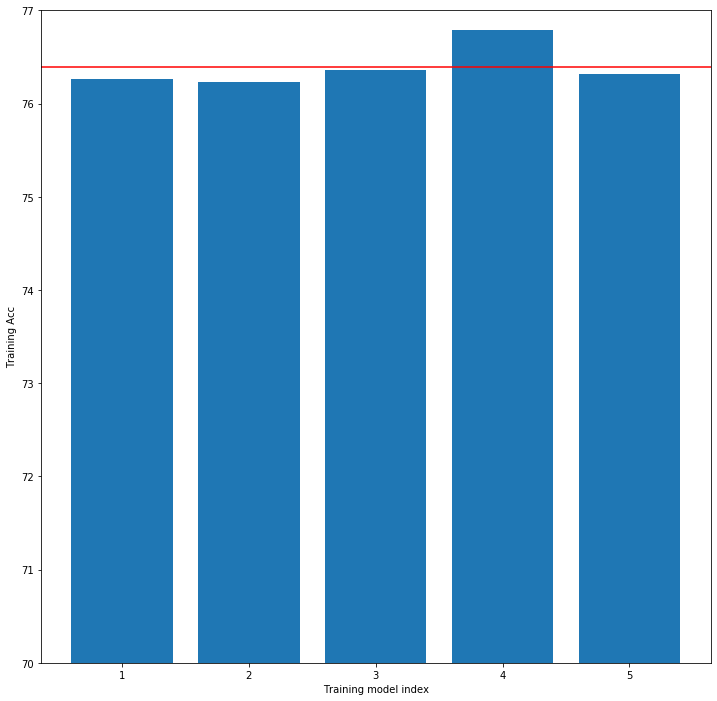

Average training acc: 76.39320000000001


[76.266, 76.232, 76.364, 76.786, 76.318]

In [20]:
model_name = 'CIFAR17_double2'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.6476, Accuracy: 38518/50000 (77%)

Trail 2


  1%|          | 12/1563 [00:00<00:13, 114.83it/s]

Test set: Average loss: 0.6163, Accuracy: 39054/50000 (78%)

Trail 3


  1%|          | 11/1563 [00:00<00:14, 109.65it/s]

Test set: Average loss: 0.6079, Accuracy: 39172/50000 (78%)

Trail 4


  1%|          | 9/1563 [00:00<00:18, 82.94it/s]

Test set: Average loss: 0.6350, Accuracy: 38701/50000 (77%)

Trail 5


100%|██████████| 1563/1563 [00:15<00:00, 98.79it/s] 


Test set: Average loss: 0.6217, Accuracy: 38862/50000 (78%)



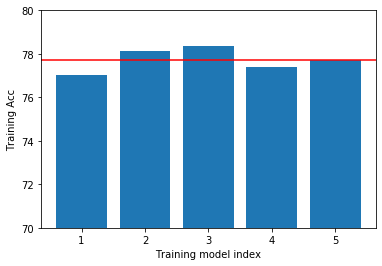

Average training acc: 77.72279999999999


[77.036, 78.108, 78.344, 77.402, 77.724]

In [6]:
model_name = 'CIFAR17_double3'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

## Increase Conv filter kernel size 

### Add to CNN1

  0%|          | 7/1563 [00:00<00:22, 69.86it/s]

Trail 1


100%|██████████| 1563/1563 [00:17<00:00, 87.57it/s] 


Test set: Average loss: 0.7452, Accuracy: 36855/50000 (74%)



  1%|          | 8/1563 [00:00<00:19, 78.77it/s]

Trail 2


100%|██████████| 1563/1563 [00:14<00:00, 106.99it/s]


Test set: Average loss: 0.7297, Accuracy: 37152/50000 (74%)



  1%|          | 9/1563 [00:00<00:18, 81.89it/s]

Trail 3


100%|██████████| 1563/1563 [00:15<00:00, 98.55it/s] 


Test set: Average loss: 0.7137, Accuracy: 37477/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 85.49it/s]

Trail 4


100%|██████████| 1563/1563 [00:15<00:00, 101.12it/s]


Test set: Average loss: 0.7053, Accuracy: 37584/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 79.68it/s]

Trail 5


100%|██████████| 1563/1563 [00:16<00:00, 95.06it/s] 


Test set: Average loss: 0.7346, Accuracy: 37182/50000 (74%)



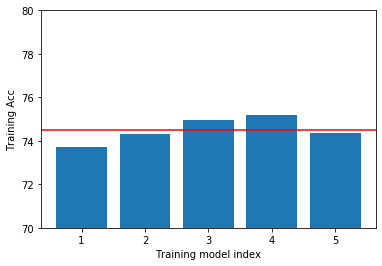

Average training acc: 74.5


[73.71, 74.304, 74.954, 75.168, 74.364]

In [7]:
model_name = 'CIFAR17_filter1'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN2

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  1%|          | 8/1563 [00:00<00:20, 77.40it/s]

Test set: Average loss: 0.6973, Accuracy: 37666/50000 (75%)

Trail 2


100%|██████████| 1563/1563 [00:14<00:00, 111.31it/s]


Test set: Average loss: 0.7096, Accuracy: 37575/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 80.13it/s]

Trail 3


100%|██████████| 1563/1563 [00:16<00:00, 96.85it/s] 


Test set: Average loss: 0.7072, Accuracy: 37488/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 84.23it/s]

Trail 4


  0%|          | 5/1563 [00:00<00:39, 39.60it/s]

Test set: Average loss: 0.7321, Accuracy: 36913/50000 (74%)

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 132.37it/s]


Test set: Average loss: 0.7144, Accuracy: 37320/50000 (75%)



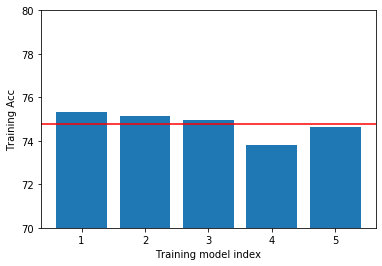

Average training acc: 74.78479999999999


[75.332, 75.15, 74.976, 73.826, 74.64]

In [8]:
model_name = 'CIFAR17_filter2'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  0%|          | 3/1563 [00:00<01:04, 24.31it/s]

Trail 1


100%|██████████| 1563/1563 [00:16<00:00, 97.08it/s] 


Test set: Average loss: 0.7022, Accuracy: 37538/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 81.39it/s]

Trail 2


100%|██████████| 1563/1563 [00:15<00:00, 101.36it/s]


Test set: Average loss: 0.7183, Accuracy: 37351/50000 (75%)



  1%|          | 8/1563 [00:00<00:21, 71.93it/s]

Trail 3


  1%|          | 9/1563 [00:00<00:18, 84.80it/s]

Test set: Average loss: 0.6819, Accuracy: 37926/50000 (76%)

Trail 4


100%|██████████| 1563/1563 [00:14<00:00, 104.41it/s]


Test set: Average loss: 0.6921, Accuracy: 37707/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 82.78it/s]

Trail 5


100%|██████████| 1563/1563 [00:17<00:00, 89.88it/s] 


Test set: Average loss: 0.6793, Accuracy: 37976/50000 (76%)



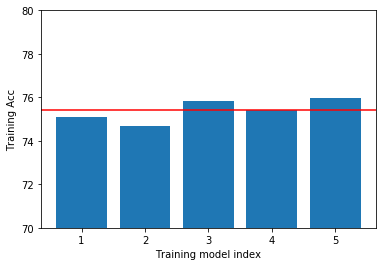

Average training acc: 75.3992


[75.076, 74.702, 75.852, 75.414, 75.952]

In [9]:
model_name = 'CIFAR17_filter3'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

In [50]:
neighbour_dict = [[1,0,0], [0,1,0], [0,0,1]]
a = [75.076, 74.702, 75.852]

In [51]:
np.asarray(neighbour_dict)[np.asarray(a) == max(a)][0]

array([0, 0, 1])